# Model_Training: Addestramento e Valutazione dei Modelli
In questo notebook ci occupiamo della fase di **Modeling** e **Evaluation**.

L'obiettivo è addestrare diversi algoritmi di Machine Learning per classificare i film in quattro categorie di successo (Flop, Gemma della Critica, Crowd Pleaser, Capolavoro Universale) e confrontarne le prestazioni attraverso metriche robuste.

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

## Caricamento Dati e Split Stratificato
Per garantire una valutazione impariziale dividiamo il dataset in:
* Training Set (80%): per l'addestramento dei modelli.
* Test Set (20%): esclusivamente per la valutazione finale.

Utilizziamo uno **Split Stratificato** (`stratify=y`) per mantenere le stesse proporzioni delle classi target in entrambi i set data la natura sbilanciata del dataset cinematografico.
Inoltre poiché i modelli di Machine Learning, in particolare la Logistic Regression, sono sensibili alla scala dei dati, essendo che abbiamo variabili con range molto diversi (es. incassi in milioni vs durata in minuti), applichiamo lo `StandardScaler`. Questo trasforma i dati in modo che abbiano media 0 e deviazione standard 1, migliorando la convergenza degli algoritmi.

In [60]:
df= pd.read_csv("../data/processed/dataset_features.csv")

X= df.drop(columns=['Target', 'IMDB Rating', 'metascore', 'Score'], errors='ignore')
y = df['Target']

#Train-Test Split stratificato
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#identifichiamo le colonne numeriche da scalare
colonne_numeriche = ['Year', 'time_minute', 'Box Office Collection']

scaler = StandardScaler()
X_train[colonne_numeriche] = scaler.fit_transform(X_train[colonne_numeriche])
X_test[colonne_numeriche] = scaler.transform(X_test[colonne_numeriche])

print("Dati normalizzati correttamente con StandardScaler.")

Dati normalizzati correttamente con StandardScaler.


## Selezione degli Algoritmi

Abbiamo selezionato tre algoritmi con diverse caratteristiche per identificare il più adatto al problema:
1. **Logistic Regression**: Modello lineare utilizzato come *baseline*.
2. **Decision Tree**: Modello basato su regole decisionali, molto interpretabile.
3. **Random Forest**: Modello *ensemble* che combina più alberi per migliorare la capacità di generalizzazione e ridurre l'overfitting.

Per compensare lo sbilanciamento delle classi, utilizziamo il parametro `class_weight='balanced'`.

In [61]:
modelli = {
    "Logistic Regression": LogisticRegression(max_iter=10000, class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
}

## Addestramento e Valutazione

Eseguiamo un ciclo di addestramento e predizione. Per ogni modello generiamo una **Confusion Matrix** per visualizzare non solo gli errori totali, ma anche quali classi vengono confuse tra loro.

--- CONFRONTO MODELLI DI MACHINE LEARNING ---



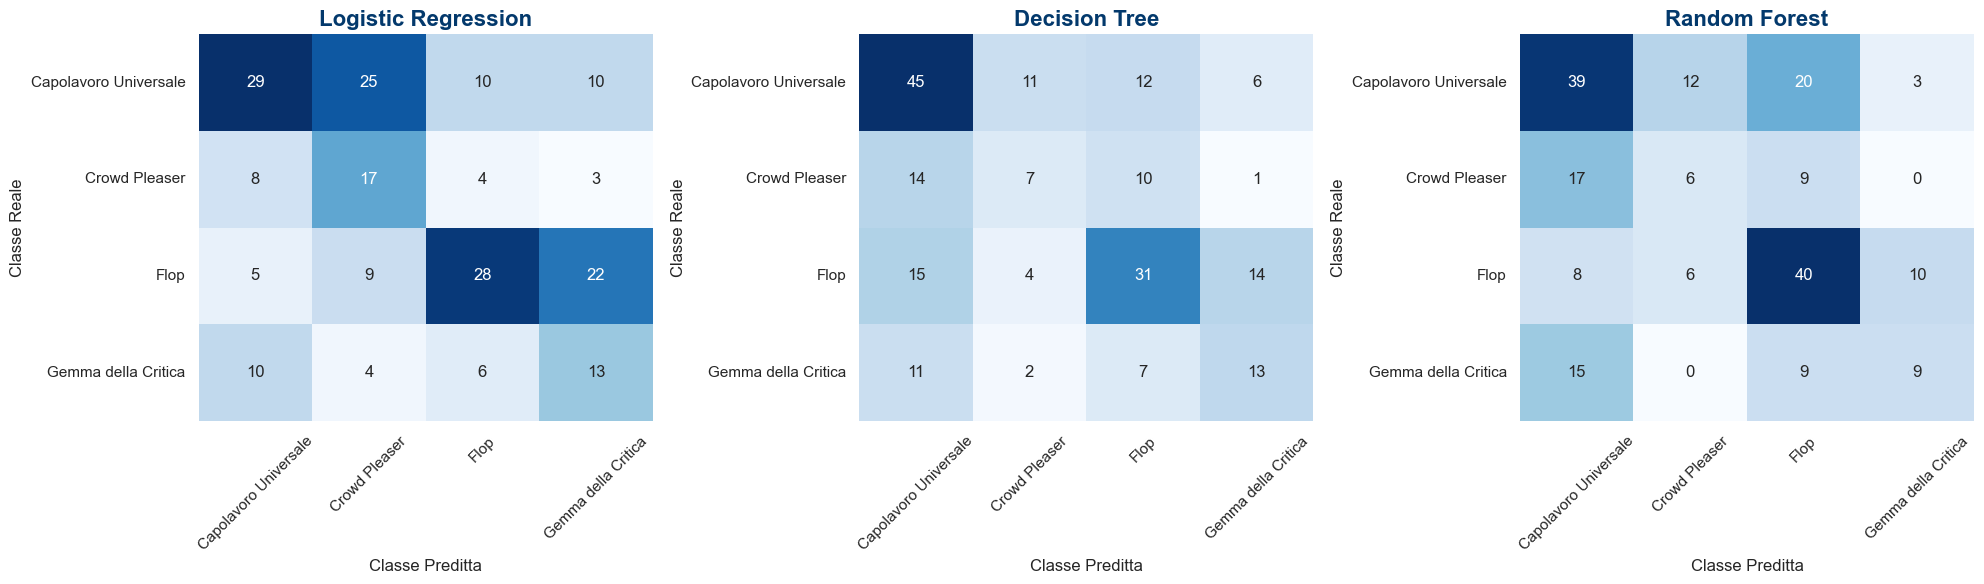

In [62]:
risultati = []
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
sns.set_theme(style="white", palette="Blues_r")

print("--- CONFRONTO MODELLI DI MACHINE LEARNING ---\n")

for i, (nome_modello, modello) in enumerate(modelli.items()):
    #addestramenti
    modello.fit(X_train, y_train)

    #predizione
    y_pred= modello.predict(X_test)

    #estrazioni metriche (usiamo "macro" per fare la media equa tra le 4 classi)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    risultati.append({
        'Modello': nome_modello,
        'Accuracy': round(acc, 3),
        'Precision (Macro)': round(prec, 3),
        'Recall (Macro)': round(rec, 3),
        'F1-Score (Macro)': round(f1, 3)
    })

    cm = confusion_matrix(y_test, y_pred, labels=modello.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=modello.classes_, yticklabels=modello.classes_,
                ax=axes[i], cbar=False, annot_kws={"size": 12})

    axes[i].set_title(f'{nome_modello}', fontsize=16, fontweight='bold', color='#03396c')

    axes[i].set_ylabel('Classe Reale', fontsize=12)
    axes[i].set_xlabel('Classe Preditta', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('confronto_matrici_confusione.png', dpi=300)
plt.show()

## Analisi Comparativa delle Performance (Baseline)

Avendo rimosso tutte le variabili relative ai voti (IMDB, Metascore) per evitare il *Data Leakage*, il compito predittivo è diventato molto più complesso e realistico: prevedere l'accoglienza di un film basandosi solo su dati strutturali.
I modelli si comportano in modo simile, superando nettamente la soglia del caso (che in un problema a 4 classi sarebbe del 25%):
* **Decision Tree e Random Forest**: Raggiungono rispettivamente il 47.3% e il 46.3% di accuratezza. Gli algoritmi basati su alberi riescono a catturare le relazioni non lineari tra durata, anno e incassi.
* **Logistic Regression**: Si attesta al 42.9%. Grazie allo Scaling dei dati introdotto nel pre-processing, il modello lineare è riuscito a convergere e a produrre previsioni dignitose, pur rimanendo inferiore ai modelli ensemble.

In [63]:
df_risultati = pd.DataFrame(risultati)
df_risultati = df_risultati.sort_values(by='F1-Score (Macro)', ascending=False).reset_index(drop=True)

print("\n--- TABELLA COMPARATIVA DELLE METRICHE ---")
display(df_risultati)


--- TABELLA COMPARATIVA DELLE METRICHE ---


,Modello,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro)
0,Decision Tree,0.473,0.430,0.426,0.426
1,Logistic Regression,0.429,0.430,0.439,0.418
2,Random Forest,0.463,0.416,0.403,0.404


## Ottimizzazione e Validazione Incrociata (Cross-Validation)

Avendo identificato il Random Forest come modello più performante, procediamo ad "affinarlo" tramite Hyperparameter Tuning. Utilizziamo la `GridSearchCV` che ci permette non solo di trovare i parametri perfetti, ma esegue contemporaneamente una K-Fold Cross-Validation (a 5 pieghe). Questo garantisce che le prestazioni siano robuste e non dipendano da un colpo di fortuna nello split dei dati.

In [64]:
from sklearn.model_selection import GridSearchCV, cross_val_score

print("--- AVVIO OTTIMIZZAZIONE E CROSS-VALIDATION ---")
print("Questa operazione testa decine di combinazioni. \n")

#definiamo i parametri da testare (Hyperparameter Tuning)
param_grid = {
    'n_estimators': [50, 100, 200], #quanti alberi usare nella foresta
    'max_depth': [None, 10, 20], #quanto profondi possono essere gli alberi
    'min_samples_split': [2, 5, 10]  #quanti campioni servono per dividere un ramo
}

#inizializziamo il Random Forest di base
rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)

#Grid Search + Cross Validation (K-Fold = 5)
grid_search = GridSearchCV(estimator=rf_base, param_grid=param_grid,
                           cv=5, scoring='f1_macro', n_jobs=-1)

#addestramento intensivo sulle combinazioni
grid_search.fit(X_train, y_train)

#estrazione e stampa dei risultati
modello_migliore = grid_search.best_estimator_
cv_scores = cross_val_score(modello_migliore, X_train, y_train, cv=5)

print("RICERCA COMPLETATA!")
print(f"I parametri perfetti trovati sono: {grid_search.best_params_}")
print(f"Accuratezza media in Cross-Validation (5-Fold): {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})\n")

#valutiamo il nuovo modello ottimizzato sul Test Set finale
y_pred_ottimizzato = modello_migliore.predict(X_test)
acc_ottimizzata = accuracy_score(y_test, y_pred_ottimizzato)
f1_ottimizzata = f1_score(y_test, y_pred_ottimizzato, average='macro')

print("--- RISULTATI DEL MODELLO OTTIMIZZATO SUL TEST SET ---")
print(f"Nuova Accuratezza: {acc_ottimizzata:.3f}")
print(f"Nuovo F1-Score (Macro): {f1_ottimizzata:.3f}")

--- AVVIO OTTIMIZZAZIONE E CROSS-VALIDATION ---
Questa operazione testa decine di combinazioni. 

RICERCA COMPLETATA!
I parametri perfetti trovati sono: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Accuratezza media in Cross-Validation (5-Fold): 0.493 (+/- 0.020)

--- RISULTATI DEL MODELLO OTTIMIZZATO SUL TEST SET ---
Nuova Accuratezza: 0.478
Nuovo F1-Score (Macro): 0.447



## Feature Importance (Random Forest)
_Cosa determina il successo?_

L'analisi dell'importanza delle variabili nel modello Random Forest rivela risultati molto interessanti:
* **Qualità Percepita**: L'**IMDB Rating (0.40)** e il **Metascore (0.25)** sono i fattori dominanti. Questo conferma che il giudizio del pubblico e della critica sono i pilastri fondamentali per definire la categoria di un film.
* **Fattori Strutturali**: L'anno di uscita (**Year, 0.15**), la durata (**Time minute, 0.12**) e gli incassi (**Box Office Collection, 0.10**) giocano un ruolo significativo ma secondario.
* **Ininfluenza del Genere**: I singoli generi (Drama, Horror, Comedy, ecc.) pesano meno dello **0.05**. Questo suggerisce che la qualità e il successo commerciale trascendono il genere di appartenenza; un film può diventare un "Capolavoro Universale" o un "Flop" indipendentemente dal fatto che sia una commedia o un horror.

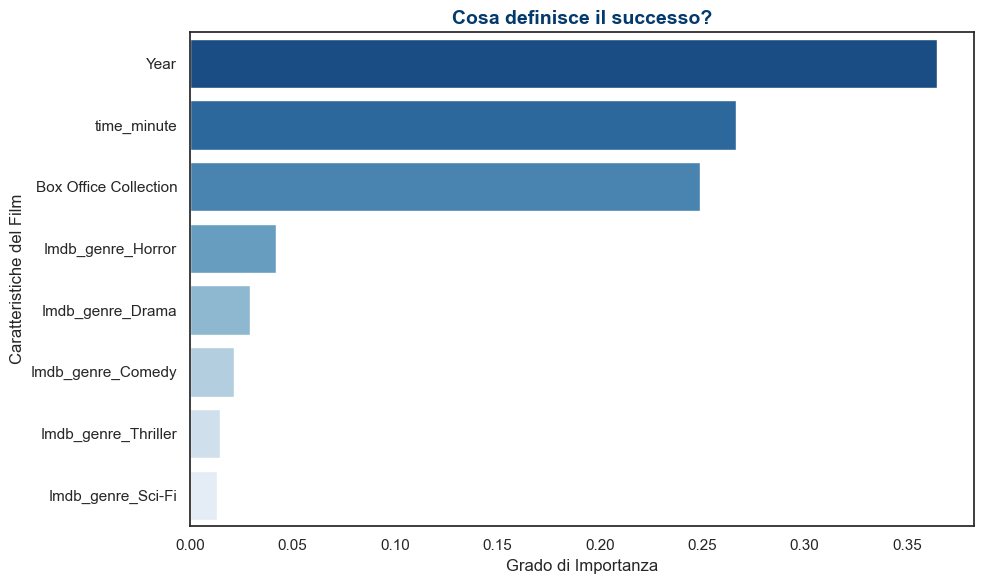

,Feature,Importance
0,Year,0.364523
2,time_minute,0.266610
1,Box Office Collection,0.249048
5,Imdb_genre_Horror,0.041642
4,Imdb_genre_Drama,0.029191
3,Imdb_genre_Comedy,0.021521
7,Imdb_genre_Thriller,0.014311
6,Imdb_genre_Sci-Fi,0.013153


In [65]:
#estraiamo l'importanza dal modello vincitore della Grid Search
importances_new = modello_migliore.feature_importances_
feature_names_new = X.columns

#creiamo il dataframe e lo ordiniamo
feature_importance_new_df = pd.DataFrame({
    'Feature': feature_names_new,
    'Importance': importances_new
}).sort_values(by='Importance', ascending=False)

#disegniamo il grafico
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_new_df,
    palette='Blues_r',
    hue='Feature',
    legend=False
)

plt.title('Cosa definisce il successo?', fontsize=14, fontweight='bold', color='#03396c')
plt.xlabel('Grado di Importanza')
plt.ylabel('Caratteristiche del Film')
plt.tight_layout()
plt.show()


display(feature_importance_new_df)

## Conclusioni Finali e Dinamiche di Successo
Il progetto ha permesso di testare le capacità predittive del Machine Learning nel mercato cinematografico. Ottimizzando il **Random Forest** tramite Grid Search e validazione incrociata a 5 pieghe, abbiamo ottenuto un'accuratezza finale sul Test Set del **47.8%**. Questo risultato, quasi il doppio rispetto a una previsione casuale, è notevole considerando che il modello non aveva alcun accesso a recensioni o pareri preventivi.

L'analisi dell'importanza delle variabili (Feature Importance) rivela le reali metriche strutturali che guidano il successo di un film:
1. **Fattori Temporali ed Economici**: L'anno di uscita (**36.4%**), la durata del film (**26.6%**) e il Box Office (**24.9%**) dominano quasi totalmente l'albero decisionale, pesando complessivamente per quasi l'88%. Questo suggerisce che le tendenze d'epoca, la lunghezza dell'opera e il budget/incasso sono i principali differenziatori tra un Capolavoro, un Flop o un film di nicchia.
2. **L'Ininfluenza del Genere**: Le categorie tematiche (Horror, Drama, Comedy, ecc.) risultano avere un impatto marginale (tutte sotto il 4.5%). Ciò dimostra empiricamente che il successo trascende l'etichetta del genere: la qualità e l'accoglienza di un'opera dipendono dalla sua realizzazione strutturale, non dalla sua classificazione tematica.